# Resolución del problema XOR con redes neuronales

#### Carga de bibliotecas y datos

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
import tensorflow as tf
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import warnings
warnings.simplefilter('ignore')
from sklearn.metrics import mean_squared_error

In [3]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 20

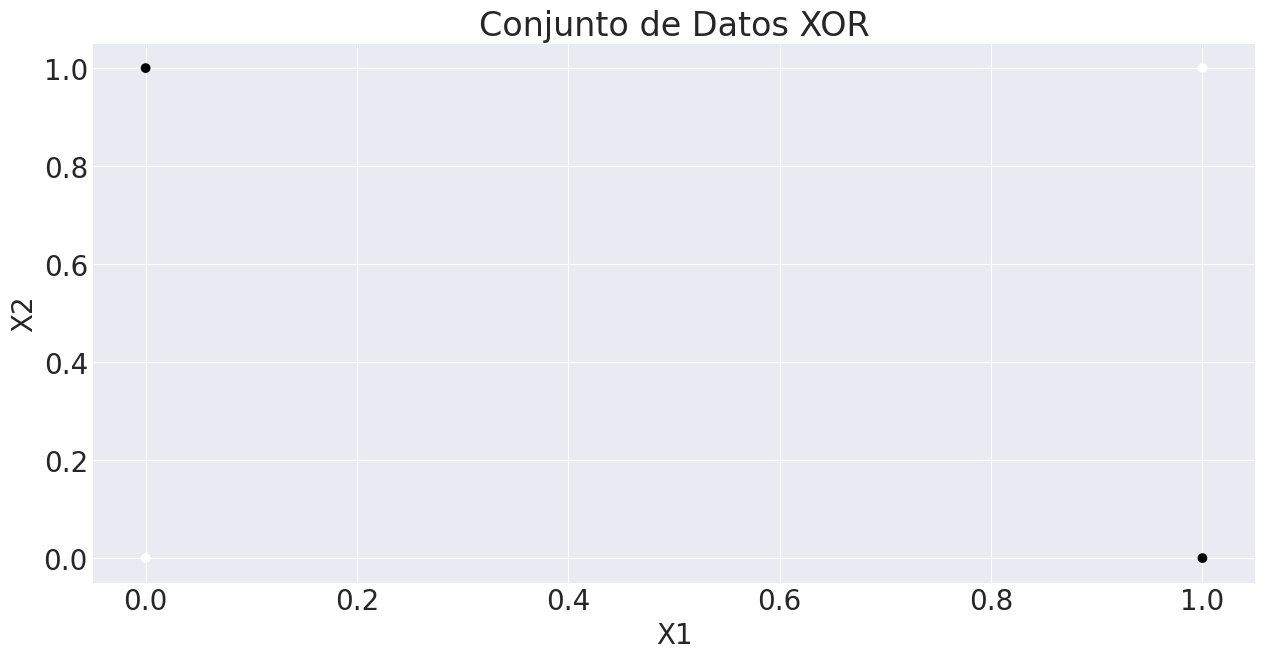

In [4]:
# Conjunto de datos XOR
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
Y = np.array([0, 1, 1, 0])

# Visualizar datos
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Conjunto de Datos XOR")
plt.show()

#### Regresión lineal

Parámetros de la regresión lineal: [ 0.00000000e+00 -2.22044605e-16] 0.5000000000000001


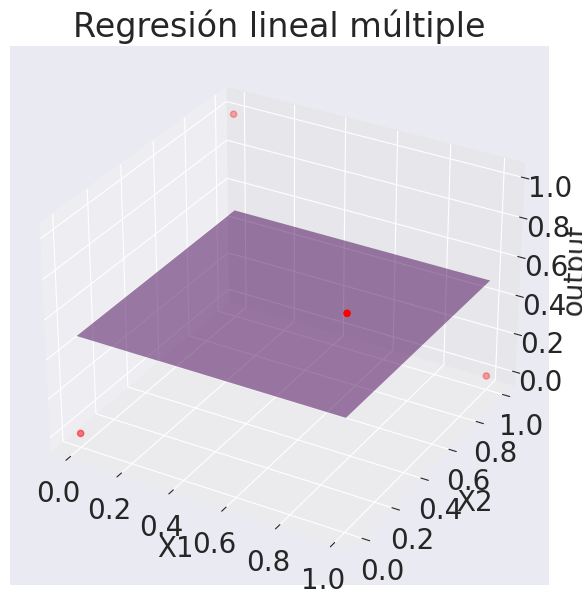

In [5]:
# se crea y entrena un modelo de regresión lineal
linear_model = LinearRegression()
linear_model.fit(X, Y)
print('Parámetros de la regresión lineal:', linear_model.coef_, linear_model.intercept_)

# Gráfico de Regresión Lineal
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Visualizar los datos
ax.scatter(X[:, 0], X[:, 1], Y, c='r', marker='o', label='Datos reales')

# Crear un plano de regresión
x_mesh, y_mesh = np.meshgrid(np.linspace(0, 1, 10), np.linspace(0, 1, 10))
z_mesh = linear_model.predict(np.c_[x_mesh.ravel(), y_mesh.ravel()])
z_mesh = z_mesh.reshape(x_mesh.shape)
ax.plot_surface(x_mesh, y_mesh, z_mesh, alpha=0.5, rstride=100, cstride=100, cmap='viridis', label='Plano de Regresión')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('output')
ax.set_title('Regresión lineal múltiple')
plt.show()

In [6]:
linear_model.predict(X)

## las predicciones son siempre 0.5, un modelo lineal no alcanza a modelizar este problema

array([0.5, 0.5, 0.5, 0.5])

In [7]:
mse_linear_model=mean_squared_error(Y, linear_model.predict(X))
mse_linear_model

0.25

### Red Neuronal con numpy

Esta red neuronal contiene una capa oculta de dos neuronas y una sola output, con lo cual tiene 9 parámetros. Estos 9 parámetros son tres por neurona (ya que la capa anterior a cada neurona tiene 2 neuronas, es decir, 2 pesos y un bias). Con lo cual se inicializan tres vectores de parámetros:

W1_1 = vector con parámetros de la neurona 1 de la capa oculta.

W2_1 = vector con parámetros de la neurona 2 de la capa oculta.

W1_2 = vector con parámetros de la neurona de salida

In [8]:
class NeuralNetwork():
    """
    Modelo de red neuronal simple con numpy
    """
    def __init__(self):
        ### inicialización de pesos de los tres vectores
        self.W1_1 = None
        self.W2_1 = None
        self.W1_2 = None

    def sigmoid(self, x):
        # Función sigmoidea para la función de activación
        g_x = 1 / (1 + np.exp(-x))
        return g_x

    def fit(self, X, y, lr=0.1, epochs=20000):

        # para medir la evolución del MSE a través de las iteraciones
        mse_epoch = []

        # se agrega una columna de unos
        X = np.append(X, np.ones(shape=(X.shape[0],1)), axis = 1)

        n = X.shape[0] # number of samples
        m = X.shape[1] # number of features

        # inicialización random de los pesos
        W1_1 = np.random.random(size=(m, 1))
        W2_1 = np.random.random(size=(m,1))
        W1_2 = np.random.random(size=(3,1))

        # se itera sobre todas las epocas
        for j in range(epochs):

            # orden random de las muestras
            idx = np.random.permutation(X.shape[0])
            X = X[idx]
            y = y[idx]

            # funcion de perdida inicial
            mse=0

            # Iteramos en el dataset (SGD)
            for i in range(n):

                # Forward propagation, con esto se obtiene la ecuación para la salida
                z1 = X[i,:]@W1_1
                z1 = z1[0]
                a1 = self.sigmoid(z1)

                z2 = X[i,:]@W2_1
                z2 = z2[0]
                a2 = self.sigmoid(z2)

                x1_2 = np.array([a1,a2,1])
                z3 = x1_2@W1_2
                z3 = z3[0]
                a3 = self.sigmoid(z3)

                prediction = a3

                # se calcula el error
                error = np.power(y[i] - prediction,2)

                # acumulo el error en la función de pérdida
                mse = mse + error

                # se calcula el gradiente, ecuaciones back propagation, recordar que la derivada de la sigmoidea es sigm(1-sigm).
                grad_W1_2 = (-2/n) * (y[i] - prediction) * self.sigmoid(z3) * (1-self.sigmoid(z3)) * x1_2
                grad_W2_1 = (-2/n) * (y[i] - prediction) * self.sigmoid(z3) * (1-self.sigmoid(z3)) * W1_2[1] * \
                            self.sigmoid(z2) * (1-self.sigmoid(z2)) * X[i,:]
                grad_W1_1 = (-2/n) * (y[i] - prediction) * self.sigmoid(z3) * (1-self.sigmoid(z3)) * W1_2[0] * \
                            self.sigmoid(z1) * (1-self.sigmoid(z1)) * X[i,:]

                # actualizo pesos
                W1_2 = W1_2 - (lr * grad_W1_2[:,np.newaxis])
                W2_1 = W2_1 - (lr * grad_W2_1[:,np.newaxis])
                W1_1 = W1_1 - (lr * grad_W1_1[:,np.newaxis])

            # se calcula error para la época, se divide por n que es la cantidad de muestras
            mse_epoch.append(mse/n)

         ### no imprimo el error por época porque llenaría la pantalla de mensajes pero lo imprimimos diez veces para ir trackeando la evolución
            if (j % (epochs/10)) == 0:
                print("Epoch ",j," MSE: ", mse/n)

        # guardamos los parametros
        self.W1_1 = W1_1
        self.W2_1 = W2_1
        self.W1_2 = W1_2

        # devolvemos el error de entrenamiento, por época, para poder graficarlo, es una medida muy útil
        return mse_epoch, W1_1, W2_1, W1_2

    def predict(self,X):

        # se agrega una columna de unos a X
        X=np.append(X, np.ones(shape=(X.shape[0],1)), axis = 1)
        n = X.shape[0]

        prediction = []

        # iteramos en el dataset que se esta prediciendo
        for i in range(n):
            # Forward propagation, acá no hay que hacer backward, no hay nada que optimizar,
            # solo hay que buscar la ecuación de predicción con los parámetros ya entrenados
            z1 = X[i,:]@self.W1_1
            z1 = z1[0]
            a1 = self.sigmoid(z1)

            z2 = X[i,:]@self.W2_1
            z2 = z2[0]
            a2 = self.sigmoid(z2)

            x1_2 = np.array([a1,a2,1])
            z3 = x1_2@self.W1_2
            z3 = z3[0]
            a3 = self.sigmoid(z3)

            prediction.append(a3)

        return np.array(prediction)

In [9]:
### Entreno mi red neuronal
model = NeuralNetwork()
mse_epoch, W1_1, W2_1, W1_2 = model.fit(X,Y, lr=0.1, epochs=10000)

### en caso que vea que el error no mejora respecto de la regresión lineal, puedo cambiar el learning_rate o la cantidad de iteraciones para la convergencia.

Epoch  0  MSE:  0.34981988248053647
Epoch  1000  MSE:  0.25024378875019476
Epoch  2000  MSE:  0.2476561235749673
Epoch  3000  MSE:  0.23971074180191304
Epoch  4000  MSE:  0.22156052062760073
Epoch  5000  MSE:  0.19768486596371326
Epoch  6000  MSE:  0.17787103114408923
Epoch  7000  MSE:  0.15441907710479727
Epoch  8000  MSE:  0.10118228797720717
Epoch  9000  MSE:  0.047853570938813636


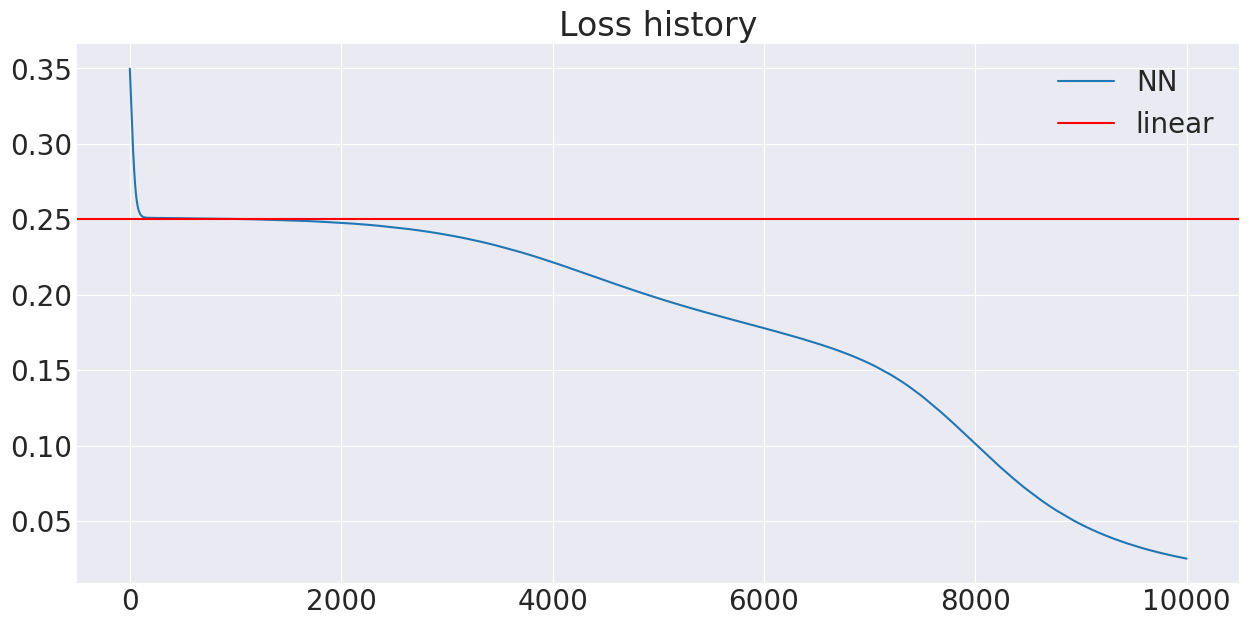

In [10]:
plt.plot(mse_epoch, label='NN')
plt.axhline(mse_linear_model, color='red', label='linear',linestyle = '-')
plt.title('Loss history')
plt.legend()
plt.show()

In [11]:
model.predict(X)

array([0.13848648, 0.84582626, 0.84636137, 0.18351268])

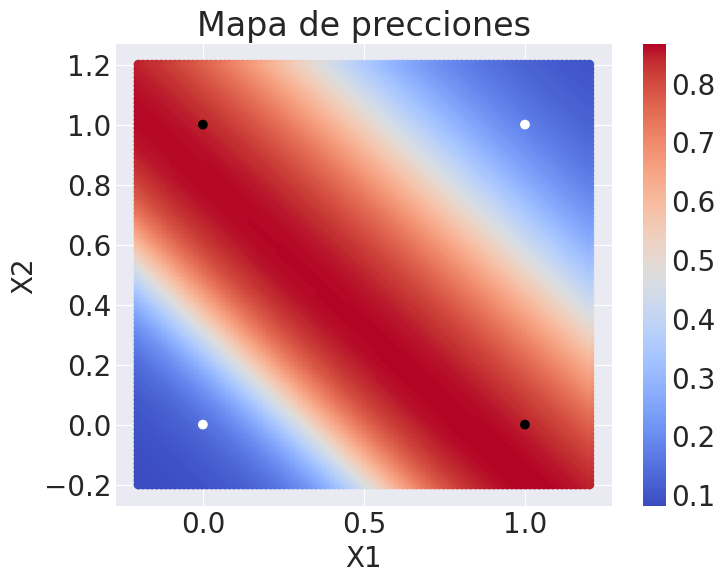

In [12]:
x1_values = np.linspace(-0.2, 1.2, 100)
x2_values = np.linspace(-0.2, 1.2, 100)

## agarramos todos los puntos de la grlla para predecir
grid_points = np.array([(x1, x2) for x1 in x1_values for x2 in x2_values])

predictions = model.predict(grid_points)

plt.figure(figsize=(8, 6))
plt.scatter(grid_points[:, 0], grid_points[:, 1], c=predictions, cmap='coolwarm')
plt.colorbar()
plt.scatter(X[:,0],X[:,1], c=Y)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Mapa de precciones')

plt.show()

### Red neuronal con tensorflow

In [13]:
class NeuralNetworkTensorFlow:
    """
        Este es un modelo simple con TensorFlow para resolver el mismo problema.
        En esta clase, (1) se construye el modelo.
        (2) Se define como se fitea el modelo
        (3) Y como se hacen las predicciones.
    """
    def __init__(self):
        self.model = self.build_model()

    def build_model(self):
        """
            Construye el modelo
            Para construir el modelo es necesario una arquitectura, un optimizador y una función de pérdida.
            La arquitectura se construye con el método Sequential, que basicamente lo que hace es colocar
            secuencialmente las capas que uno desea.
            Las capas "Dense" son las fully connected dadas en clase.
            Se agrega una capa oculta que recibe un input de tamaño 2,
            y una capa de salida de regresión (una única neurona)
            En todos los casos se define una sigmoidea como función de activación (prueben otras!)

            El optimizador y la función de pérdida se especifican dentro de un compilador.

            Con este método, lo que se devuelve es el modelo sin entrenar, sería equivalente a escribir LinearRegression()
            en el caso de la regresión lineal.
        """

        model = tf.keras.Sequential([
            tf.keras.layers.Dense(2, activation='sigmoid', input_shape=(2,)),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        ### imprimimos la cantidad de parámetros a modo de ejemplo
        print("n° de parámetros:", model.count_params())
        return model

    def fit(self, X, y, lr=0.1, epochs=20000):
        ### esta es la función donde se entrena el modelo, fijarse que hay un learning rate e iteraciones.
        ### la función que fitea devuelve una historia de pérdida, que vamos a guardar para graficar la evolución.
        X = np.array(X)
        y = np.array(y)
        history = self.model.fit(X, y, epochs=epochs, verbose=0)
        return history.history['loss']

    def predict(self, X):
        X = np.array(X)
        predictions = self.model.predict(X)
        return predictions

In [14]:
nn_tensorflow = NeuralNetworkTensorFlow()
loss_history = nn_tensorflow.fit(X, Y, lr=1, epochs=10000)

n° de parámetros: 9


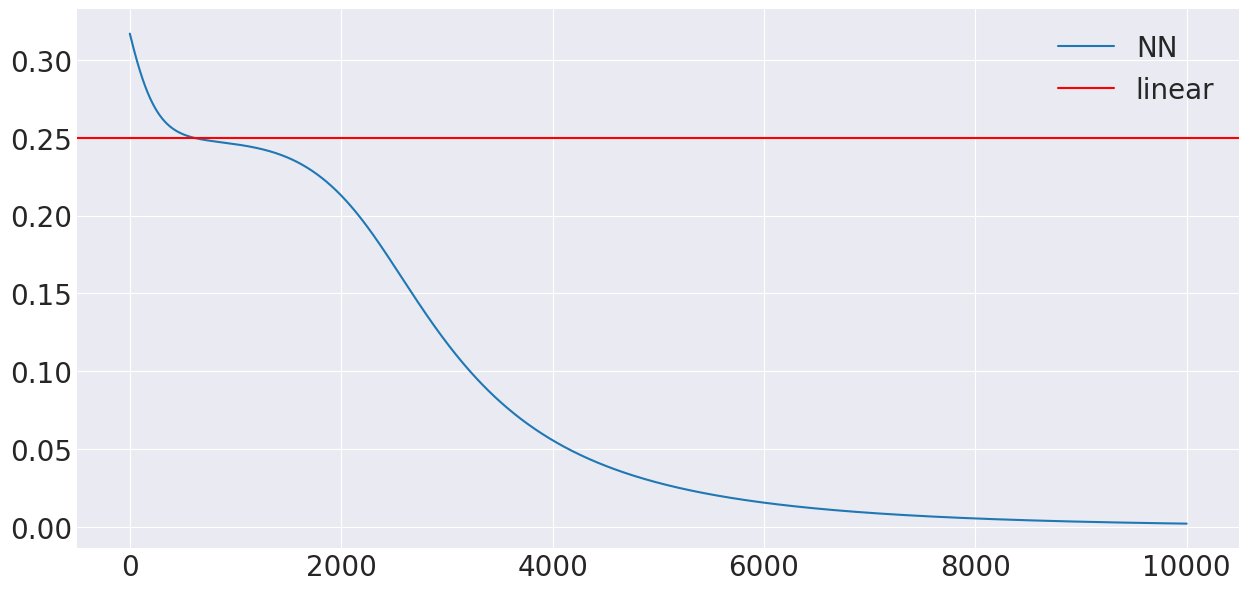

In [15]:
plt.plot(loss_history, label='NN')
plt.axhline(mse_linear_model, color='red', label='linear',linestyle = '-')
plt.legend()
plt.show()

In [16]:
predictions = nn_tensorflow.predict(X)
print("Predicciones:", predictions)

1/1 [==============================] - 0s 79ms/step
Predicciones: [[0.04783602]
 [0.95068395]
 [0.96051663]
 [0.04452766]]


313/313 [==============================] - 1s 2ms/step


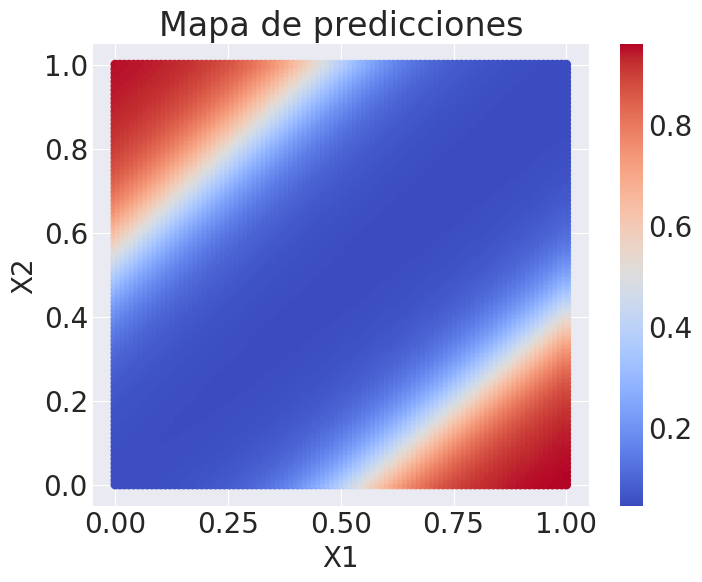

In [17]:
x1_values = np.linspace(0, 1, 100)
x2_values = np.linspace(0, 1, 100)
grid_points = np.array([(x1, x2) for x1 in x1_values for x2 in x2_values])

predictions = nn_tensorflow.predict(grid_points)

plt.figure(figsize=(8, 6))
plt.scatter(grid_points[:, 0], grid_points[:, 1], c=predictions, cmap='coolwarm')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Mapa de predicciones')
plt.colorbar()
plt.show()

In [18]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

class NeuralNetworkPytorch(nn.Module):
    """
        PyTorch requiere definir secuencialmente las funciones de la red neuronal
        En este caso se especifica primero una neurona lineal de 2 inputs y 2 neuronas (output)
        Luego una sigmoidea de activación
        Luego una neurona lineal de 2 inputs y 1 neurona (output)
        y por último una activación.

        Notar que se podría hacer con un bucle, con hiperparámetros de entrada.

        Luego requiere que se defina la acción forward. Internamente, ya conoce como hacer el backward, acorde a las
        funciones que se hayan ido seleccionando.

    """
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 2)
        self.sigmoid1 = nn.Sigmoid()
        self.fc2 = nn.Linear(2, 1)
        self.sigmoid2 = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid1(x)
        x = self.fc2(x)
        x = self.sigmoid2(x)
        return x

nnet = NeuralNetworkPytorch()
print(nnet)

NeuralNetworkPytorch(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
  (sigmoid1): Sigmoid()
  (fc2): Linear(in_features=2, out_features=1, bias=True)
  (sigmoid2): Sigmoid()
)


In [19]:
print([p for p in nnet.parameters()])

## los parámetros están puestos por capa, e inicializados aleatoriamente al comienzo.
## notarán que son "tensores": básicamente son np.arrays, pero pueden correr con GPU
## puesto que las redes neuronales entrenan una gran cantidad de parámetros, sería óptimo contar con un poder de procesamiento
## computacional interesante (una unidad de procesamiento gráfico que pueda ejecutar la tarea de entrenar estos parámetros
# de forma más eficiente)

[Parameter containing:
tensor([[ 0.0251,  0.3114],
        [-0.1587, -0.4897]], requires_grad=True), Parameter containing:
tensor([-0.1368, -0.2012], requires_grad=True), Parameter containing:
tensor([[0.3530, 0.3999]], requires_grad=True), Parameter containing:
tensor([0.6609], requires_grad=True)]


In [20]:
print(sum(p.numel() for p in nnet.parameters())) #numel devuelve la cantidad total de elementos de un tensor
### Cantidad de parámetros.

9


In [21]:
### defino mi función de pérdida, MSELoss en este caso
loss_function = torch.nn.MSELoss()
### defino un optimizador, SGD en este caso, con un learning rate, y le decimos cuales son los paarámetros a optimizar.
optimizer = torch.optim.SGD(nnet.parameters(), lr=0.1)

In [22]:
class MyDataset(Dataset):
    ### esta clase cambia la forma de los datos de entrenamiento

    #__init__ guarda el dataset en una variable de clase
    def __init__(self, x, y):
      self.x = x
      self.y = y

    # __len__ define el comportamiento de la función len() sobre el objeto
    def __len__(self):
      return self.x.shape[0]

    # __getitem__ define el comportamiento de los []
    def __getitem__(self, idx):
      return self.x[idx], self.y[idx]

In [23]:
train_ds = MyDataset(X, Y)

In [24]:
train_ds[1]

(array([0, 1]), 1)

In [25]:
len(train_ds)

4

In [26]:
# Pytorch utiliza DataLoader para entregar los dataset de a batches
# en este caso el batch size lo ponemos como 1 porque solo son 4 datos
# pero si se tienen muchos más datos, se toman valores más grandes.
train_dataloader = DataLoader(train_ds, batch_size = 1, shuffle= True)

In [27]:
# esto es para usar GPU en caso de tenerla disponible
device = "cpu"
if torch.cuda.is_available():
  device = "cuda:0"

device

'cpu'

In [28]:
# cantidad de epochs
epochs = 10000

train_loss_by_epoch=[]
valid_loss_by_epoch=[]

# Doble loop algoritmo Mini-Batch
for epoch in range(epochs):

    ############################################
    ## Entrenamiento
    ############################################
    nnet.train(True)

    epoch_loss = 0
    epoch_y_hat = []
    epoch_y = []

    for i,data in enumerate(train_dataloader):
        # Obtengo los datos del batch de entrenamiento
        x_batch, y_batch = data
        # Copio el batch al dispositivo donde entreno la red neuronal
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float().reshape(-1, 1)

        # Paso forward
        # Limpio optimizer para empezar un nuevo cálculo de gradiente
        optimizer.zero_grad()
        nnet_output = nnet(x_batch)
        y_batch_hat = torch.sigmoid(nnet_output)

        # Calculo el loss
        loss = loss_function(nnet_output, y_batch)

        # Backpropagation, no hace falta detallar las derivadas como con numpy, pero sí hay que llamar al método.
        loss.backward()

        # Actualizar los parámetros, se utiliza step del optimizador.
        optimizer.step()

        # Almaceno los valores reales y mis predicciones para cálcular las métricas
        epoch_y += list(y_batch.detach().cpu().numpy())
        epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())
        # Acumulo la loss del batch
        epoch_loss = epoch_loss + loss.item()

    # Calculo la media de la loss
    epoch_loss = epoch_loss / len(train_ds)
    # Almaceno la loss de la epoch para graficar
    train_loss_by_epoch.append(epoch_loss)

    ############################################
  ## Impresión de resultados por epoch
  ############################################
    print(f" Epoch {epoch} | " \
        f"Train loss: {epoch_loss:.3f} | ")

Streaming output truncated to the last 5000 lines.
 Epoch 5000 | Train loss: 0.034 | 
 Epoch 5001 | Train loss: 0.034 | 
 Epoch 5002 | Train loss: 0.034 | 
 Epoch 5003 | Train loss: 0.034 | 
 Epoch 5004 | Train loss: 0.033 | 
 Epoch 5005 | Train loss: 0.033 | 
 Epoch 5006 | Train loss: 0.033 | 
 Epoch 5007 | Train loss: 0.033 | 
 Epoch 5008 | Train loss: 0.033 | 
 Epoch 5009 | Train loss: 0.033 | 
 Epoch 5010 | Train loss: 0.033 | 
 Epoch 5011 | Train loss: 0.033 | 
 Epoch 5012 | Train loss: 0.033 | 
 Epoch 5013 | Train loss: 0.033 | 
 Epoch 5014 | Train loss: 0.033 | 
 Epoch 5015 | Train loss: 0.033 | 
 Epoch 5016 | Train loss: 0.033 | 
 Epoch 5017 | Train loss: 0.032 | 
 Epoch 5018 | Train loss: 0.032 | 
 Epoch 5019 | Train loss: 0.032 | 
 Epoch 5020 | Train loss: 0.032 | 
 Epoch 5021 | Train loss: 0.032 | 
 Epoch 5022 | Train loss: 0.032 | 
 Epoch 5023 | Train loss: 0.032 | 
 Epoch 5024 | Train loss: 0.032 | 
 Epoch 5025 | Train loss: 0.032 | 
 Epoch 5026 | Train loss: 0.032 | 
 Epo

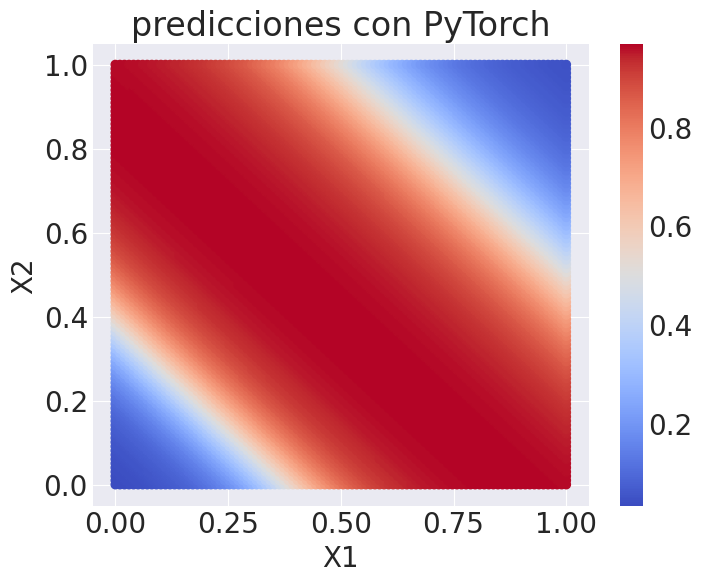

In [29]:
x1_values = np.linspace(0, 1, 100)
x2_values = np.linspace(0, 1, 100)
grid_points = np.array([(x1, x2) for x1 in x1_values for x2 in x2_values])

inputs = torch.Tensor(grid_points)
predictions = nnet(inputs).detach().numpy()

# Graficar los resultados
plt.figure(figsize=(8, 6))
plt.scatter(grid_points[:, 0], grid_points[:, 1], c=predictions, cmap='coolwarm')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('predicciones con PyTorch')
plt.colorbar()
plt.show()